In [13]:
import os
import numpy as np
import tensorflow as tf
from matplotlib import pyplot as plt
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Normalization, RandomHeight, RandomWidth, RandomFlip, RandomRotation

from utils.data_loader import DataLoader

In [14]:
data_loader = DataLoader('split_data_white_padded')

train_data_path = '/train'
test_data_path = '/test'
validation_data_path = '/validation'

IMAGE_SIZE = 256
BATCH_SIZE = 32
SHUFFLE = True

train_dataset = data_loader.load_image_data(train_data_path, IMAGE_SIZE, BATCH_SIZE, SHUFFLE)
validation_dataset = data_loader.load_image_data(validation_data_path, IMAGE_SIZE, BATCH_SIZE, not SHUFFLE)
test_dataset = data_loader.load_image_data(test_data_path, IMAGE_SIZE, BATCH_SIZE, not SHUFFLE)

Found 4121 files belonging to 2 classes.
Found 1152 files belonging to 2 classes.
Found 577 files belonging to 2 classes.


In [15]:
normalization = Normalization(axis=None)

# calculate mean and standard deviation over all training samples and normalize all data
train_images = train_dataset.map(lambda x, y: x)
normalization.adapt(train_images)

In [16]:
data_augmentation = Sequential()
data_augmentation.add(RandomFlip("horizontal"))
data_augmentation.add(RandomRotation(0.1))

In [17]:
AUTOTUNE = tf.data.AUTOTUNE

def preprocess(dataset, augment=False):
  # Resize and rescale all datasets.
  dataset = dataset.map(lambda x, y: (normalization(x), y), 
              num_parallel_calls=AUTOTUNE)

  # Use data augmentation only on the training set.
  if augment:
    dataset = dataset.map(lambda x, y: (data_augmentation(x), y), 
                num_parallel_calls=AUTOTUNE)

  # Use buffered prefetching on all datasets.
  return dataset.prefetch(buffer_size=AUTOTUNE)

In [18]:
train_dataset = preprocess(train_dataset, augment=True)
validation_dataset = preprocess(validation_dataset)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tf.Tensor([0 0 0 1 1 0 0 0 0 1 0 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 1], shape=(32,), dtype=int32)


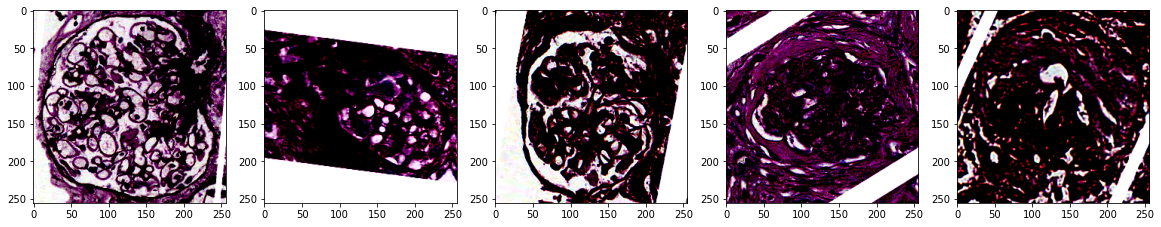

In [19]:
def display(ds):
    images, labels = next(iter(ds.take(5)))
    print(labels)
    fig, ax = plt.subplots(ncols=5, figsize=(20,20))
    for idx, img in enumerate(images[:5]):
        ax[idx].imshow(img.numpy())

display(train_dataset)

In [20]:
# instantiate an empty sequential model
logistic_regression_model = Sequential()
logistic_regression_model.add(Flatten(input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3)))
logistic_regression_model.add(Dense(1, activation='sigmoid'))

logistic_regression_model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 196608)            0         
                                                                 
 dense (Dense)               (None, 1)                 196609    
                                                                 
Total params: 196609 (768.00 KB)
Trainable params: 196609 (768.00 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [21]:
optimizer = Adam(learning_rate=0.0001)

# Compile the model
logistic_regression_model.compile(optimizer=optimizer, loss="binary_crossentropy", metrics=["accuracy"])

# Train the model with your loaded data using the data loader
history = logistic_regression_model.fit(train_dataset, epochs=20, validation_data=validation_dataset)

Epoch 1/20


129/129 [==============================] - 70s 529ms/step - loss: 0.6882 - accuracy: 0.7678 - val_loss: 0.4744 - val_accuracy: 0.8108
Epoch 2/20
129/129 [==============================] - 42s 309ms/step - loss: 0.5344 - accuracy: 0.8173 - val_loss: 0.4439 - val_accuracy: 0.8220
Epoch 3/20
129/129 [==============================] - 31s 228ms/step - loss: 0.3976 - accuracy: 0.8546 - val_loss: 0.4154 - val_accuracy: 0.8707
Epoch 4/20
129/129 [==============================] - 31s 227ms/step - loss: 0.4184 - accuracy: 0.8527 - val_loss: 0.3897 - val_accuracy: 0.8576
Epoch 5/20
129/129 [==============================] - 33s 241ms/step - loss: 0.3923 - accuracy: 0.8619 - val_loss: 0.3779 - val_accuracy: 0.8481
Epoch 6/20
129/129 [==============================] - 31s 230ms/step - loss: 0.4110 - accuracy: 0.8644 - val_loss: 0.4962 - val_accuracy: 0.8481
Epoch 7/20
129/129 [==============================] - 32s 232ms/step - loss: 0.4211 - accuracy: 0.8663 - val_loss: 0.5079 - val_

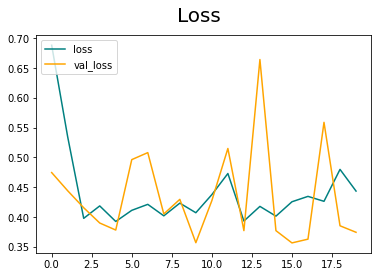

In [22]:
fig = plt.figure()
plt.plot(history.history['loss'], color='teal', label='loss')
plt.plot(history.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

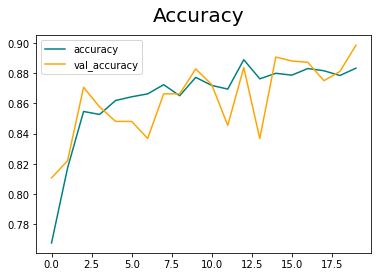

In [24]:
fig = plt.figure()
plt.plot(history.history['accuracy'], color='teal', label='accuracy')
plt.plot(history.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

In [25]:
test_dataset_normalized = preprocess(test_dataset)

19/19 [==============================] - 2s 116ms/step - loss: 0.4561 - accuracy: 0.8718
Test accuracy: 0.8717504143714905
19/19 [==============================] - 2s 107ms/step


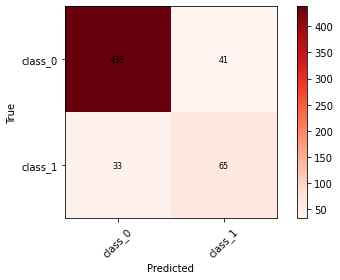

In [26]:
# Evaluate the model
loss, accuracy = logistic_regression_model.evaluate(test_dataset_normalized)
print("Test accuracy:", accuracy)

# Generate predictions for confusion matrix
y_pred = logistic_regression_model.predict(test_dataset_normalized)
y_pred_classes = tf.where(y_pred > 0.5, 1, 0)
y_true = tf.concat([y for _, y in test_dataset], axis=0)

# Calculate and plot confusion matrix
cm = tf.math.confusion_matrix(y_true, y_pred_classes)
# Annotate each cell with the corresponding value

plt.imshow(cm, cmap=plt.cm.Reds)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.xticks(range(len(test_dataset.class_names)), test_dataset.class_names, rotation=45)
plt.yticks(range(len(test_dataset.class_names)), test_dataset.class_names)
plt.colorbar()
for i in range(len(cm)):
    for j in range(len(cm)):
        value = cm[i, j].numpy()
        plt.text(i, j, value, ha='center', va='center', fontsize=8)
plt.tight_layout()
plt.show()